# AllLife Bank - Customer Segmentation
## Summary
AllLife bank is looking to run personalized advertising campaigns to target new customers and upsell their existing customers. They also have been informed that customers view their customer response and services are poor. Therefore, the bank is also interested in improving there service of customers as well as obtaining new ones.

#### Purpose: AllLife Bank wants to understand the breakdown of the different customers they serve. They intend to use this information to carry out targeted advertising to existing and new potential customers as well as improve their service to the different types of customers they serve.

### Objectives:
- Identify different segments within the existing customers using clustering algorithms based on spending patterns and past interactions with AllLife Bank
- Propose ways the bank can better market themselves to and service those types of customers

## Data Dictionary
1. Sl_no: Primary key of the records
2. Customer Key: Customer identification number
3. Average Credit Limit: Average credit limit of each customer on all their credit cards
4. Total credit cards: Total number of credit cards posessed by the customer
5. Total visits bank: Total number of visits the customer made in person to the bank (yearly)
6. Total visits online: Total number of visits or logins made by the customer (yearly)
7. Total call made: Total number of calls made by customer to the bank or the customer service dept (yearly)

In [1]:
"""Packages imported for the analysis"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

sns.set_style("darkgrid")

%matplotlib inline

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from beepy import beep

# To scale data
from sklearn.preprocessing import StandardScaler

# To compute distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

# For hierarchical clustering analysis
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# For k-means clustering analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# For PCA
from sklearn.decomposition import PCA



In [2]:
"""Import dataset and format into a basic dataframe"""
data = pd.read_excel("Credit Card Customer Data.xlsx")
raw_df = data.copy()
del data

## Initial Assessment and univariate EDA

In [3]:
"""Assessment of data type, organization, and Nans"""
print(f'Datset has {raw_df.shape[0]} rows and {raw_df.shape[1]} columns.') # Assess dataset shape
raw_df.isna().sum() # Number of Nans within each feature

Datset has 660 rows and 7 columns.


Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [4]:
# Check for duplicates
print(f'Dataset has {raw_df.duplicated().sum()} duplicate rows present.')

Dataset has 0 duplicate rows present.


In [5]:
raw_df.info() # Datatypes and counts (info) for the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
raw_df.sample(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
450,451,11265,51000,7,3,2,0
0,1,87073,100000,2,1,1,0
381,382,45878,19000,4,2,0,1
379,380,24702,6000,7,2,0,3
170,171,98602,7000,2,1,2,8
281,282,21233,14000,7,2,0,0
378,379,11398,12000,6,5,2,1
264,265,24808,17000,4,4,1,2
363,364,71862,6000,5,2,0,1
196,197,69704,14000,2,0,2,8


#### Notes
- There are no NaNs within the dataset that will need to be interpolated
- There are no duplicate rows within the dataset
- The datatypes of all the rows are integers, which is appropriate. All values will be round integers.
- **Sl_No** and **Customer Key** are likely to be unique for the dataset. Will need to verify, but if so will **Sl_No** as index to keep consistency with bank database and drop **Customer Key** as it will be unnecessary as a second unique idenifier.
- **Customer Key** needs an underscore in the column title
- All other columns should remain as they may be relevant features to segmenting the customers

In [7]:
# If unique Sl_No and Customer Key should have 660 unique values
raw_df.rename(columns={"Customer Key":"Customer_Key"}, inplace=True)
print(f"The number of unique values in SI_No are: {raw_df.Sl_No.nunique()}")
print(f"The number of unique values in Customer_Key are: {raw_df.Customer_Key.nunique()}")

The number of unique values in SI_No are: 660
The number of unique values in Customer_Key are: 655


**There are duplicates in Customer Key** which will have to assessed for why and if that issue needs to be addressed.

In [8]:
raw_df[raw_df.Customer_Key.duplicated()]

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,333,47437,17000,7,3,1,0
398,399,96929,67000,6,2,2,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


The duplication event only occurs five times in the dataset and never for the same customer key twice.

In [9]:
dup_keys = raw_df.Customer_Key[raw_df.Customer_Key.duplicated()].to_list()
for i in dup_keys:
    print(raw_df[raw_df.Customer_Key == i])
    print('*' * 50)

     Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
4        5         47437            100000                   6   
332    333         47437             17000                   7   

     Total_visits_bank  Total_visits_online  Total_calls_made  
4                    0                   12                 3  
332                  3                    1                 0  
**************************************************
     Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
391    392         96929             13000                   4   
398    399         96929             67000                   6   

     Total_visits_bank  Total_visits_online  Total_calls_made  
391                  5                    0                 0  
398                  2                    2                 2  
**************************************************
     Sl_No  Customer_Key  Avg_Credit_Limit  Total_Credit_Cards  \
48      49         37252              6000        

It is unclear exactly why these customers are duplicated. However, it may simply be that they have two different lines of credit with AllLife Bank; an initial account and a later one. As all second entries for the customer have a higher number of total cards. Regardless, **as it is only 5 entries out of 660 I will simply drop Customer_Key during cleaning and treat the entries as 'separate' customer profiles to categorized.**

In [10]:
def hist_boxplot(df, feature, figsize=(12, 7), kde=False):
    """
    Boxplot and histogram plotted on same axes for easy comparison
    for a single variable.
    
    df: dataframe for data
    feature: column of interest
    figsize: size of figure
    kde: whether to plot the kde for the histogram
    bins: number of bins for the histogram
    """
    fig, (ax_box2, ax_hist2) = plt.subplots(nrows=2, sharex=True,
                                           gridspec_kw={'height_ratios': (0.25, 0.75)},
                                           figsize=figsize)
    sns.boxplot(data=df, x=feature, ax=ax_box2, showmeans=True)
    sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist2)
    ax_hist2.axvline(df[feature].median(), color='black', linestyle='-')
    ax_hist2.axvline(df[feature].mean(), color='green', linestyle='--')

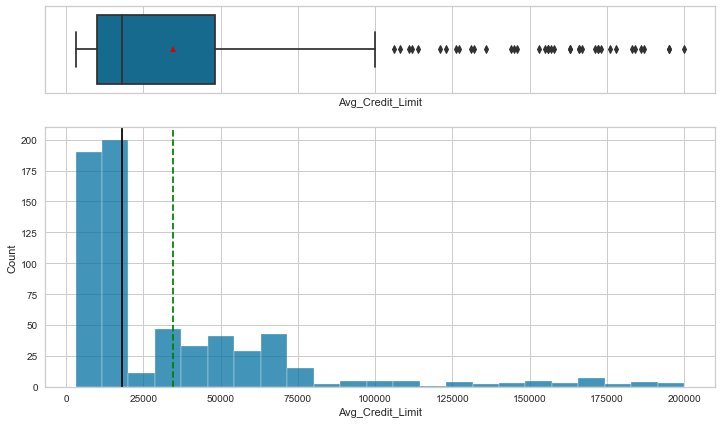

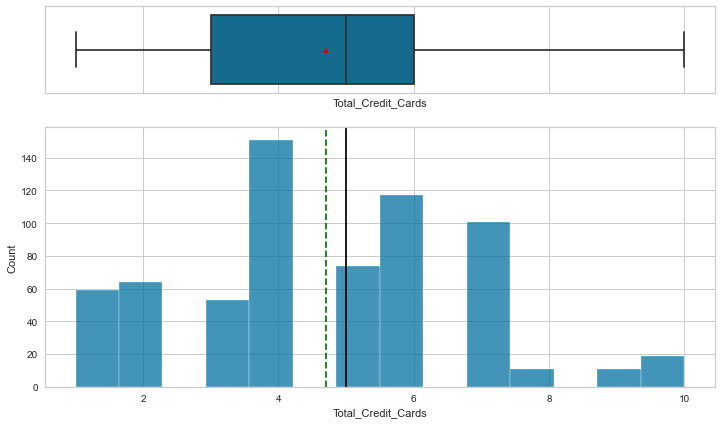

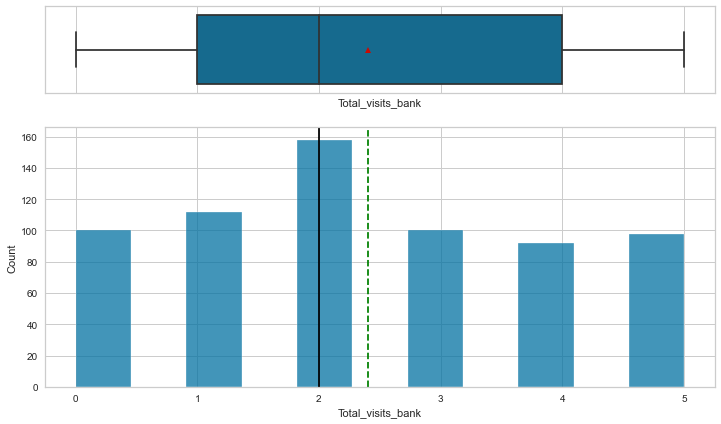

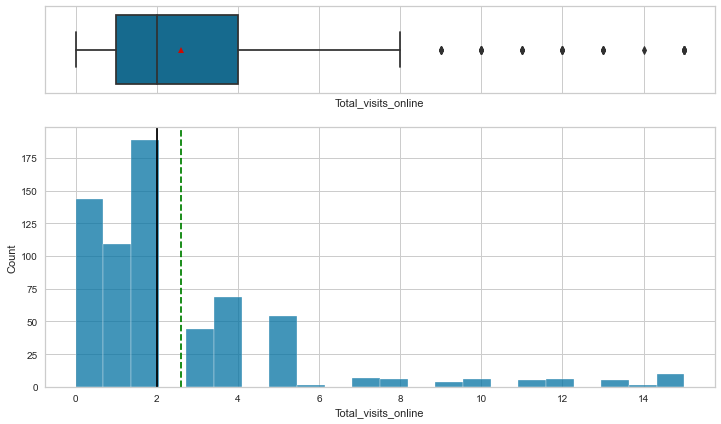

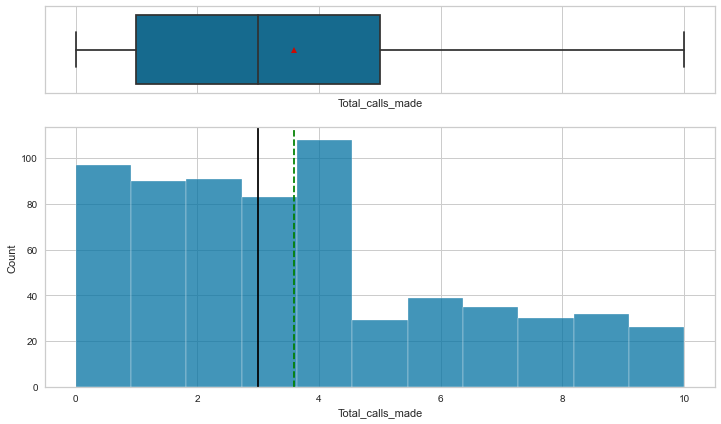

In [11]:
"""Examine the distributions of the various features"""
features = raw_df.columns[2:].to_list()
for i in range(len(features)):
    hist_boxplot(raw_df, features[i])

#### Notes
- **Avg_Credit_Limit** is heavily right skewed with a number of outliers. However, all the values appear to be true values and therefore I will not treat any.
- **Total_Credit_Card, Total_visits_bank, and Total_call_made** do not have any outliers that will need to treated.
- **Total_visits_online** is also right skewed with outliers, but also does not appear to have any erroneous values. Therefore, the outliers will be maintained for this analysis as opposed to treating them, which could remove useful variation within the customers for segmentation.

In [12]:
"""Examine basic descriptive statistics for the features"""
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer_Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


#### Notes
- The average credit limit of all customers is \\$34,574.24 $\pm$ \\$37,625.49. **A large amount of variance exists within this distribution.** The minimum credit limit is \\$3,000, while the largest is \\$200,000.
- The average number of credit cards held by a customer is 4.7 $\pm$ 2.2.
- The average number of yearly visits to the bank by a customer was 2.4 $\pm$ 1.6, which is similar to the number of online visits with an average of 2.6 $\pm$ 2.9.
- The max value for online visits in substantially higher at a 15, compared to 5 visits fro in person.
- Phone calls with the bank have an average of 3.6 $\pm$ 2.9 yearly.

In [13]:
def barplot_annot(dataframe, feature, annot='percent', 
                   n=None, h=0, w=0, s = 12):
    """
    Barplot with percentage annotation of counts on top.
    
    dataframe: dataframe containing relevant data 
    feature: columns in dataframe to be plotted
    annot: whether to annotate plots with percent, count, or both
    n: displays the top n catgory levels (default is None, i.e., display all levels)
    h: vertical position of annotation above bar
    w: lateral position of annotation above bar
    s: fontsize for annotations
    
    """
    rows = len(dataframe[feature])
    count = dataframe[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize(n + 1, 5))
        
    ax = sns.countplot(data=dataframe, x=feature, 
                       order=dataframe[feature].value_counts().index[:n].sort_values(), palette='muted')
    for p in ax.patches:
        if annot == 'percent':
            label = "{:.1f}%".format(100 * p.get_height()/rows)
        elif annot == 'count':
            label = p.get_height()
        else:
            perc = "{:.1f}%".format(100 * p.get_height()/rows)
            num = p.get_height()
            label = "{} ({})".format(num, perc)

        x = p.get_x() + p.get_width() / 2 - p.get_width() * w
        y = p.get_y() + p.get_height() + p.get_height() * h
        
        ax.annotate(label, (x, y), size = s)
    
#     plt.tight_layout()
    plt.title(feature, fontsize=25)
    sns.despine()
    plt.savefig(feature, bbox_inches='tight', dpi=300)
    plt.show()

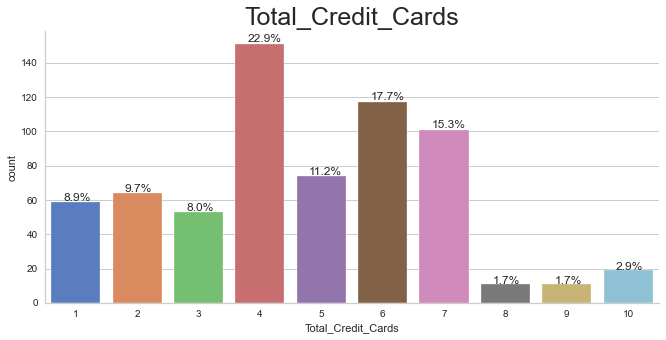

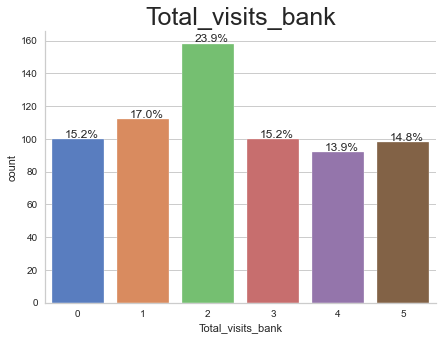

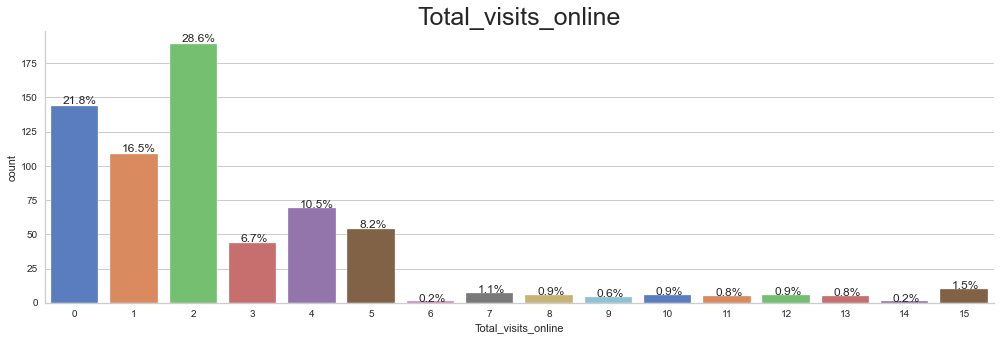

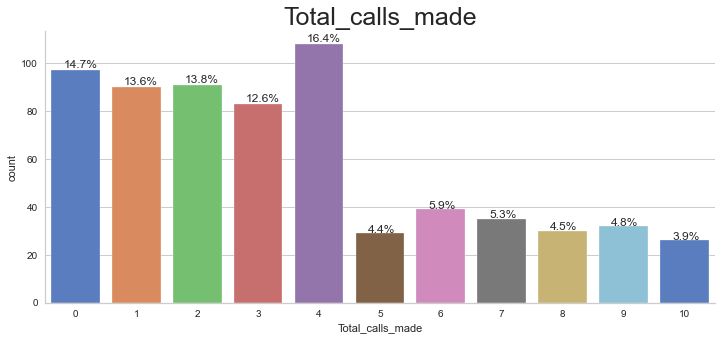

In [14]:
"""Examine frequency of various numerical count datapoints (how many credit cards etc.)"""
features = raw_df.columns[3:].to_list()
for i in range(len(features)):
    barplot_annot(raw_df, features[i], h=0.01, w=0.25)

#### Notes
- Only 6.3% of customers have 8 or more credit cards, 67% have between 4 and 7 cards.
- The most common number of visits to the bank in person is 2 (for 23.9% of the customers).
- 15.2% of customers **do not visit the bank in person at all.**
- The most a customer is known to visit the bank in a year is 5 (for 14.8% of customers).
- **The majority of customers (91.8%) visit the bank online 5 or fewer times.** The remaining customers visited bewteen 6 and upt to 15 times.
- **The majority of customers (71.1%) called the bank 4 or fewer times.** The remaining customers called between 5 or 10 times.


## Data cleaning to be done
1. Make Sl_No the index of the dataset
2. Drop Customer_Key from the dataset

In [15]:
"""Create dataframe to clean and complete EDA with"""
eda_df = raw_df.copy() # Copy dataframe from raw
# del raw_df # Remove raw dataframe

In [16]:
eda_df.set_index('Sl_No', inplace=True) # Set index as Sl_No
eda_df.drop(columns='Customer_Key', inplace=True) # Drop Customer_Key from dataset
eda_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,
1,100000,2,1,1,0
2,50000,3,0,10,9
3,50000,7,1,3,4
4,30000,5,1,1,4
5,100000,6,0,12,3


In [17]:
"""Examine the descriptive stats of the features"""
eda_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


## Bivariate Exploratory Data Analysis

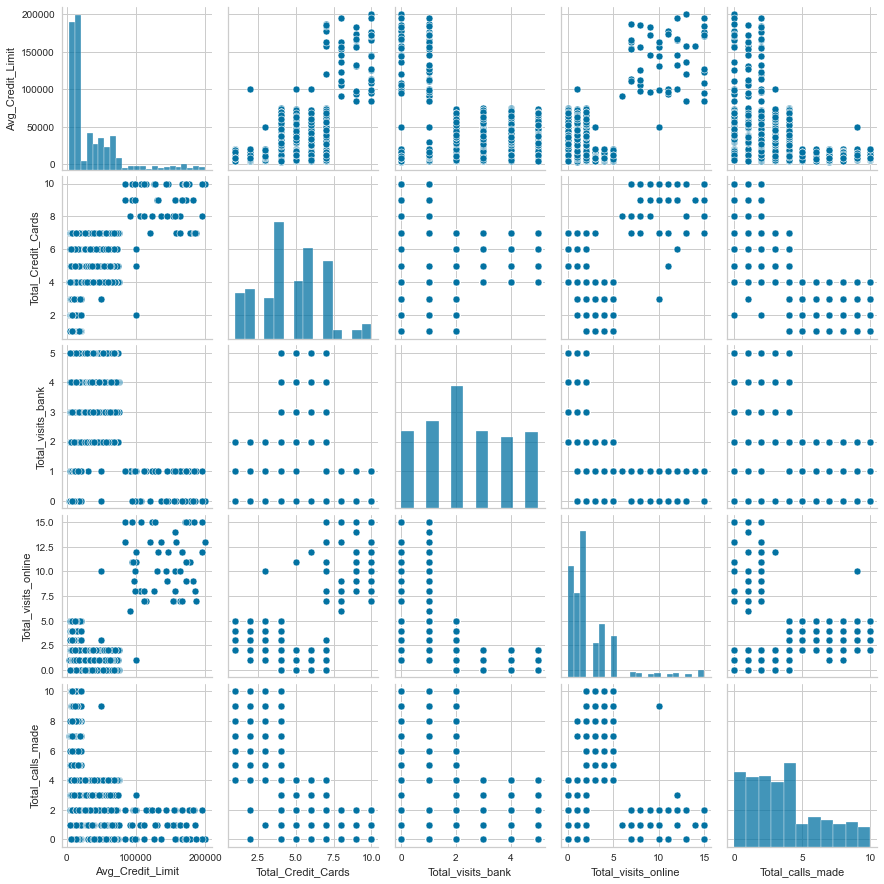

In [18]:
# Assess general bivariate trends between features
sns.pairplot(eda_df)

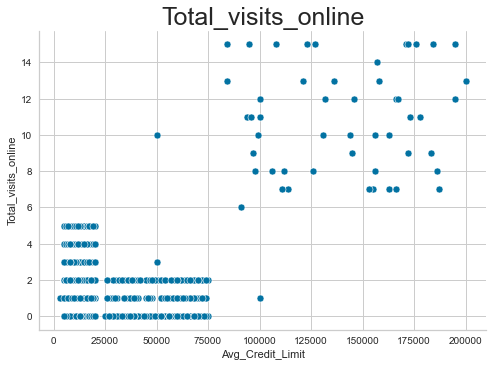

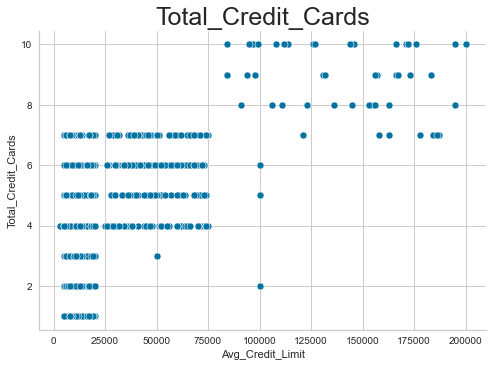

In [19]:
feature = ["Total_visits_online", "Total_Credit_Cards"]
for i in feature:
    sns.scatterplot(data=eda_df, x="Avg_Credit_Limit", y=i)

    plt.title(i, fontsize=25)
    sns.despine()
    name = i + '_CCAVG0'
    plt.savefig(name, bbox_inches='tight', dpi=300)
    plt.show()

#### Notes
- There is clear grouping between some features.
- **Avg_Credit_Limit** and **Total_visits_online** visually appears to have two strong clusters with most customers having low credit limites and fewer visits online. While those few customers with higher credit limits (greater than \\$100,000) tend to visit the bank online much more often.
- Related, the trend appears to be inverted for personal visits to the bank. **Customers with lower credit limits (less than \\$100,000) tend to visit the bank in person multiple times a year, while many of those with greater credit limits only visit once or not at all.**
- **Total number of credit cards tend to be greater for those individuals with greater credit limit.**
- **More credit cards lends itself to fewer phone calls to the bank.** Those with fewer cards tend to call the bank more often.
- **More credit cards lends itself to more visits online to the bank.**
- **More visits online lends itself to fewer phone calls to the bank.**

<AxesSubplot:>

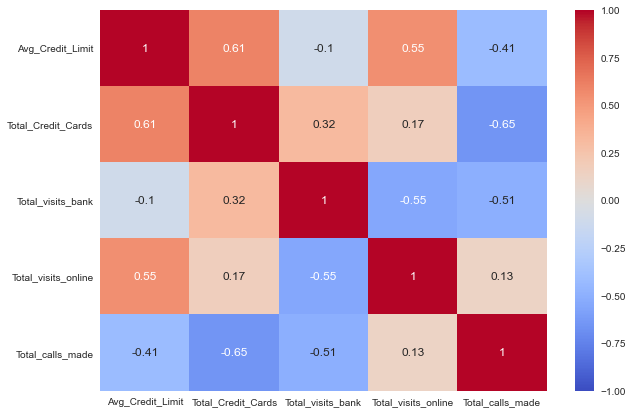

In [20]:
# Assess the presence of correlations among the features
plt.figure(figsize=(10, 7))
sns.heatmap(eda_df.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

#### Notes
- **Total_Credit_Cards** and **Avg_Credit_Limit** has the strongest positive correlation (0.61).
- **Total_Credit_Cards** and **Total_calls_made** have the strongest negative correlation (-0.65).
- **Total_calls_made** is generall negative correlated with **Avg_Credit_Limit, Total_Credit_Cards, and Total_visits_bank**.
- The weakest correlatin in the dataset is between **Total_visits_bank** and **Avg_Credit_Limit**.

### Preliminary assessment of customer segments
**There appear to be at least 2 segments. Likely more, but difficult to draw those delineations.** 
1. One has very high average credit limits, more credit cards than most, and appear to do most of their business online and have limited contact with the bank except through online.
2. The rest of the customers make up the remaining segment. There may be additional segments within this group, but clearer methods will be needed to make those delineations. Generally, these customers have fewer cards and lower average credit card limits. How they interact with bank may be variable or mixed between in-person, online, and phone calls. It is along these lines that other groups may be formed. For instance, members of this group with the fewest cards (5 or lower) appear to prefer to call the bank on the phone more than customers with more cards.

## K-means Cluster Analysis

In [21]:
"""Copy clean dataframe to carry out cluster analyses with"""
cluster_df = eda_df.copy() # Copy dataframe from eda dataframe
# del eda_df # Remove eda dataframe

In [22]:
"""Scale the data before clustering"""
scaler = StandardScaler() # Initiate standard scaler
toscale = cluster_df.copy() # create copy of dataframe to scale
scaled = scaler.fit_transform(toscale) # Fit and transform dataframe with standard scaler

scaled_df = pd.DataFrame(scaled, columns=toscale.columns) # convert scaled values into a dataframe
scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


Number of clusters: 1 	Average Distortion: 2.0069222262503614
Number of clusters: 2 	Average Distortion: 1.4571553548514269
Number of clusters: 3 	Average Distortion: 1.1466276549150365
Number of clusters: 4 	Average Distortion: 1.0463825294774465
Number of clusters: 5 	Average Distortion: 0.9908683849620168
Number of clusters: 6 	Average Distortion: 0.9429733447212403
Number of clusters: 7 	Average Distortion: 0.9096560689729589
Number of clusters: 8 	Average Distortion: 0.8900990817057112
Number of clusters: 9 	Average Distortion: 0.8663935678463088
Number of clusters: 10 	Average Distortion: 0.8438343710219425
Number of clusters: 11 	Average Distortion: 0.8259918922683945


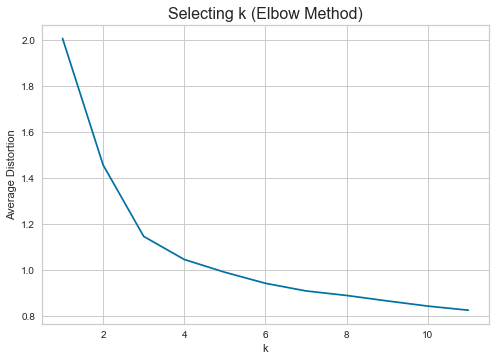

In [23]:
"""Use the Elbow method to assess how many clusters should be used for K-Means analysis"""
clusters = range(1, 12) # Set range of clusters to examine
meanDistortions = [] # Initiate empty array to store mean distortions

for k in clusters:
    model = KMeans(n_clusters=k) # initiate model with a number of clusters between 1 and 12
    model.fit(scaled_df) # Fit this clustering model to the scaled dataset
    prediction = model.predict(scaled_df) # Generate predictions for clusters
    # Calculate average distortion values for the clusters based on euclidean distances
    distortion = (
    sum(np.min(cdist(scaled_df, model.cluster_centers_, "euclidean"), axis=1))
    / scaled_df.shape[0]) 
    
    meanDistortions.append(distortion) # Append distortion for those clusters to the array
    
    print(f"Number of clusters: {k} \tAverage Distortion: {distortion}")

# Plot average distortion values for each number of clusters
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k (Elbow Method)", fontsize=16)
plt.savefig("Elbow_Method", bbox_inches='tight', dpi=300)

#### Notes
- There is a strong elbow at k = 3; sugessting that 3 clusters could be the best number of clusters without overparsing the data into groups.

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2726898791817692
For n_clusters = 6, silhouette score is 0.255906765297388
For n_clusters = 7, silhouette score is 0.24791254258020035
For n_clusters = 8, silhouette score is 0.22533090024157534
For n_clusters = 9, silhouette score is 0.21109513845387412
For n_clusters = 10, silhouette score is 0.20977286372105858
For n_clusters = 11, silhouette score is 0.2163182629162546
For n_clusters = 12, silhouette score is 0.21128813301044091


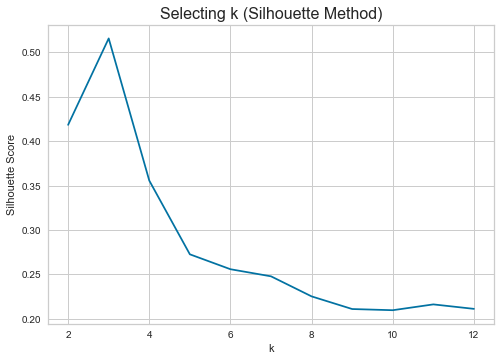

In [24]:
"""Use the silhouette scores to assess how many clusters should be used for a K-Means analysis"""
sil_score = [] # Initiate empty array to store silhouette scores
cluster_list = list(range(2, 13)) # Create range of cluster values to test
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters) # Initiate KMeans model
    preds = clusterer.fit_predict((scaled_df)) # Fit model to data and generate predicted clusters
    score = silhouette_score(scaled_df, preds) # Extract silhouette score for those clusters
    sil_score.append(score) # Append to array fr the scores
    print(f"For n_clusters = {n_clusters}, silhouette score is {score}")

# Plot silhouette scores for each number of clusters
plt.plot(cluster_list, sil_score)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Selecting k (Silhouette Method)", fontsize=16)
plt.savefig("SilhouetteMethod", bbox_inches='tight', dpi=300)

#### Notes
- The silhoutte scores peak at 3 clusters, implying that 3 is likely the best number of clusters to use for a K-Means analysis.

### Both the Elbow Method and the Silhouette Method suggest that a k=3 is the best number of clusters for this dataset. Therefore, we will proceed with a K-Means Cluster analysis of the customers assuming there are 3 different segments within the customers.

In [25]:
"""Run K-Means Cluster Analysis of the Customer data"""
rando = 42 # Set Random State
kmeans = KMeans(n_clusters=3, random_state = rando) # Initiate K-Means Cluster Model
kmeans.fit(scaled_df) # Fit K-Means model to the scaled customer data

# Add columns to non-scaled data of the groups the model generated
cluster_df["KMeans_segments"] = kmeans.labels_ 
cluster_profile = cluster_df.groupby("KMeans_segments").mean() # Group data by clusters from analysis

In [26]:
# Generate dataframe of data grouped by K-means cluster labels and highlight max values for each column
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KMeans_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


#### Notes
- The first group (0), **is largely defined by the most personal visits to the bank and the fewest visits online.** They are the middle group on all other features.
- The second group (1), has **the strongest preference for calling in to the bank, the fewest credit cards, average credit limit, and fewest visits online.**
- The third group (2), **have the highest average credit limit, most credit cards, and most online visits.** They have the least visits to the bank and calls made. They seem to dislike personal interaction when it comes to their bank.

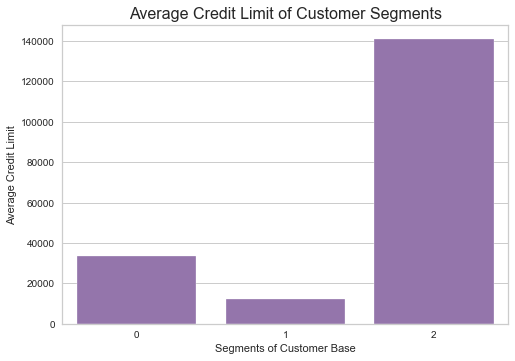

In [27]:
sb_colors = sns.color_palette('muted')
pal= sb_colors.as_hex()
sns.barplot(data=cluster_profile, 
            x = cluster_profile.index, 
            y = cluster_profile.Avg_Credit_Limit, 
            color=pal[4])

plt.xlabel("Segments of Customer Base")
plt.ylabel("Average Credit Limit")
plt.title("Average Credit Limit of Customer Segments", fontsize=16)
plt.savefig("Avg_CC_Limit_Segmented", bbox_inches='tight', dpi=300)

#### Notes
- The last segement (2) has substantially more average credit card limit than either of the other two segments.
- Segement 1 has the lowest average credit card limit.

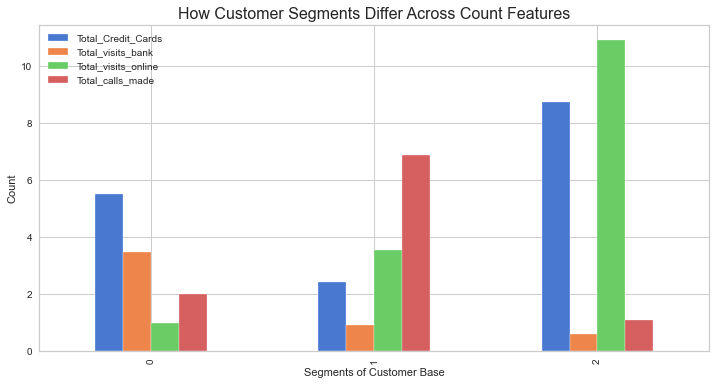

In [28]:
sb_colors = sns.color_palette('muted')
pal= sb_colors.as_hex()
cluster_df.groupby("KMeans_segments").mean().drop(columns="Avg_Credit_Limit").plot.bar(figsize=(12, 6), color=pal)

plt.xlabel("Segments of Customer Base")
plt.ylabel("Count")
plt.title("How Customer Segments Differ Across Count Features", fontsize=16)
plt.savefig("OtherFeatures_Segmented", bbox_inches='tight', dpi=300)

#### Notes
- Segment 2 has the most credit cards and a signifant preference to visit the bank online.
- Segment 1 has the strongest preference to interact with the bank over the phone and has the least number of credit cards.
- Segment 0 has the strongest preference for visiting in person.

### K-means clustering appears to have worked well. Trends follow some of the ones seen in EDA, while also breaking down one group further into customers:
- Customers who prefer use the phone to interact with the bank and have the fewest cards and average credit limit 
- Customers who have more cards, slightly higher average credit limits, and prefer to visit the bank in person.

**Both of which are separate from the obvious group observed in EDA who have many cards, the highest average credit card limit, and prefer to interact through online services.**

## Hierarchical Clustering Analysis

In [29]:
"""Use Hierarchical Clustering to assess potential segments in the customer base"""
# List different distance metric that can be uses in analysis
distance_metrics = ['euclidean', 'chebyshev', 'mahalanobis', 'cityblock']
# List a sample of different linkage methods that can be used in the analysis
linkage_methods = ['single', 'complete', 'average', 'weighted']

high_cophenet_corr = 0 # Initialize a minimum cophenet correlation value of 0
# Intitate 2D array for Distance Metric and Linkage of highest cophenet correlation
high_dm_lm = [0, 0] 

for dm in distance_metrics: # Loop through all distance metrics
    for lm in linkage_methods: # Nested loop for all linkage methods
        Z = linkage(scaled_df, metric=dm, method=lm) # Create linkages
        c, coph_dist = cophenet(Z, pdist(scaled_df)) # Extract corr value and coph_dist
        print(f"Cophenetic correlation for {dm.capitalize()} distance and {lm} linkage is {c}.")
        
        # For current highest correlation value, input distance metric and linkage method into array
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [30]:
print(f"Highest cophenetic correlation is {high_cophenet_corr}, which is obtained with {high_dm_lm[0]} distance and {high_dm_lm[1]} linkage.")

Highest cophenetic correlation is 0.8977080867389372, which is obtained with euclidean distance and average linkage.


#### The best result so far is with euclidean distance as the metric and average as the linkage method. That said, this test was with a limited number of linkage method options, therefore, the analysis will be tested solely with a euclidean metric against a broader array of linkage methods.

In [31]:
# Expanded list of linkage methods to test
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]


high_cophenet_corr = 0 # Initialize a minimum cophenet correlation value of 0
# Intitate 2D array for Distance Metric and Linkage of highest cophenet correlation
high_dm_lm = [0,0]

for lm in linkage_methods: # Loop through all linkage methods
    Z = linkage(scaled_df, metric="euclidean", method=lm) # Create linkages
    c, coph_dists = cophenet(Z, pdist(scaled_df))# Extract corr value and coph_dist
    print(f"Cophenetic correlation for {lm} linkage is {c}.")
    
    # For current highest correlation value, input distance metric and linkage method into array
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [32]:
print(f"Highest cophenetic correlatin is {high_cophenet_corr}, which is obtained with {high_dm_lm[1]} linkage")

Highest cophenetic correlatin is 0.8977080867389372, which is obtained with average linkage


#### Average linkage method remained the best option. Euclidean is likely the best metric with Average as the linkage method for these dendrograms. To ensure, and check for cluster number dendrograms will be plotted and assessed for the same array of linkages with euclidean as the metric.

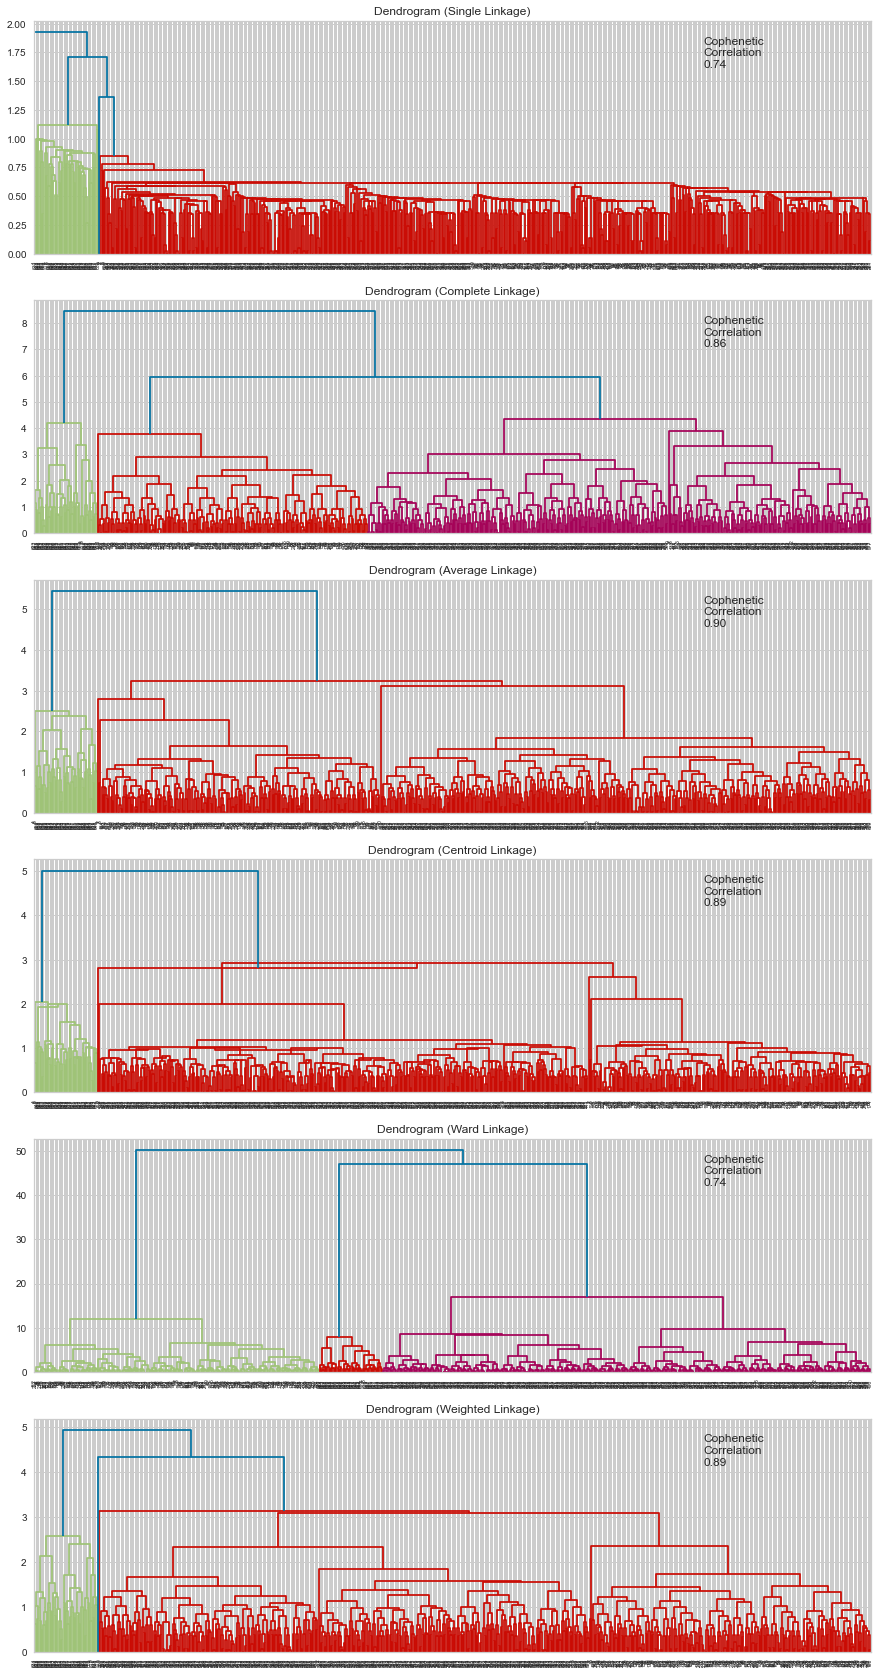

In [33]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# Enumerate through the list of linkage methods
# For each linkage method plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(scaled_df, metric="euclidean", method=method) # Create linkages

    dendrogram(Z, ax=axs[i]) # Initiate dendrograms
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

#### Notes
- **Avereage linkage method** is the best performing (Coph_corr = 0.90).
- The **Average linkage dendrogram** has 2 major groups, but within one there is a clear divide suggesting 3 different segementations between the population.
- Similar patterns of 3 large segments begin detected are present in Ward, Centroid, and Complete linkage methods as well.

**Will proceed with an analysis using Euclidean as the distance metric, Average as the linkage method, and k=3 as the number of clusters.**

In [34]:
"""Use agglomerative clustering on the customer dataset"""
# Initialize Agglomerative Custering Model
monarch = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average") 
monarch.fit(scaled_df) # Fit model to the scaled data

AgglomerativeClustering(linkage='average', n_clusters=3)

In [35]:
scaled_df["Monarch"] = monarch.labels_ # Extract labels from clustering and append to scaled dataset
cluster_df["Monarch"] = monarch.labels_ # Extract labels from clustering and append to dataset

In [36]:
# Create profile dataset of mean values for feature based on groups from aggolmerative clustering
monarch_profile = cluster_df.groupby("Monarch").mean().drop(columns="KMeans_segments")
# Generate dataframe of data grouped by Agglomerative cluster labels and highlight max values for each column 
monarch_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Monarch,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


**Groups appear nearly identical to those generated by K-Means clustering, except assigned different labels. Segments 2 and 1 are flipped compared to the K-Means results.**
- The results are slightly different the means of several values vary slightly, such as the mean Total_calls_made being slightly greater for the max in this segmentation. However, the differences are incredibly slight.

Text(0.5, 1.0, 'Average Credit Limit of Customer Segments')

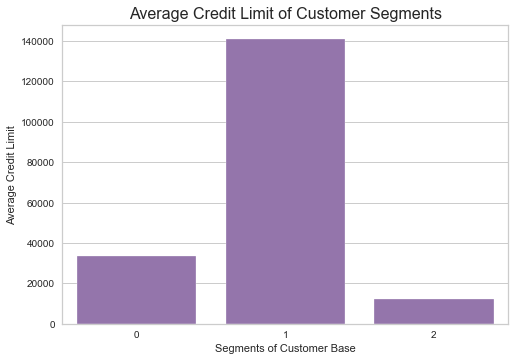

In [37]:
sb_colors = sns.color_palette('muted')
pal= sb_colors.as_hex()
sns.barplot(data=monarch_profile,
            x = monarch_profile.index,
            y = monarch_profile.Avg_Credit_Limit, 
            color=pal[4])

plt.xlabel("Segments of Customer Base")
plt.ylabel("Average Credit Limit")
plt.title("Average Credit Limit of Customer Segments", fontsize=16)

Text(0.5, 1.0, 'How Customer Segments Differ Across Count Features')

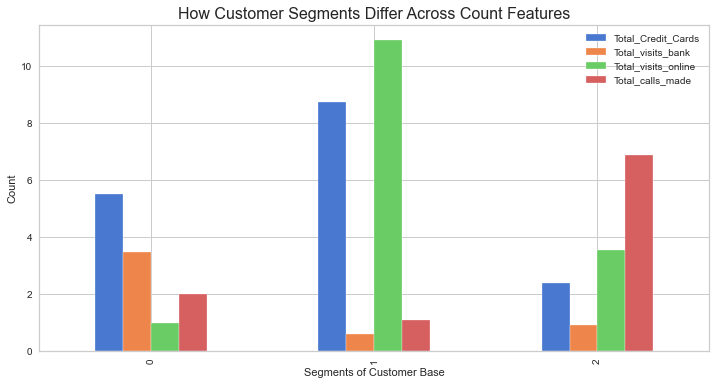

In [38]:
sb_colors = sns.color_palette('muted')
pal= sb_colors.as_hex()
cluster_df.drop(columns="KMeans_segments").groupby("Monarch").mean().drop(columns="Avg_Credit_Limit").plot.bar(figsize=(12, 6), color=pal)

plt.xlabel("Segments of Customer Base")
plt.ylabel("Count")
plt.title("How Customer Segments Differ Across Count Features", fontsize=16)

#### The figures reinforce the idea that both clustering methods are segmenting the customers in a nearly identical fashion.

### Therefore, I will recommend using the K-means clustering analysis for this dataset, due to the highly similar results but less computationally heavy method - in anticipation of the dataset potentially increasing in size in the future.

## Re-examine the data to better understand how the cluster analysis is segmenting the customers

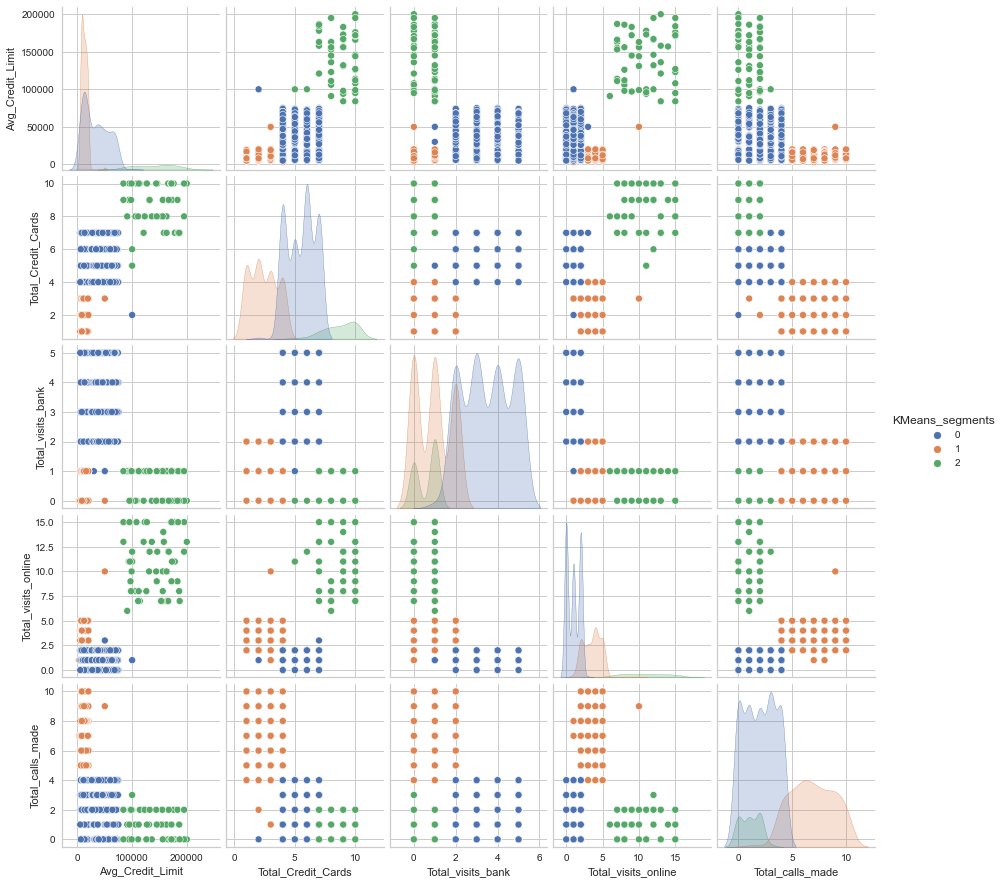

In [39]:
sns.pairplot(data=cluster_df.drop(columns="Monarch"), hue="KMeans_segments", palette='deep')

#### Notes
- You can clearly see that segment two is more distinct from the other two. Especially when it comes to Average Credit Limit, Number of Credit Cards, and Visits Online. The primary features that distinguish it from the other two segments.

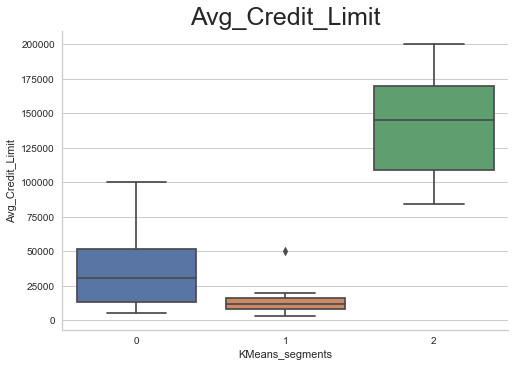

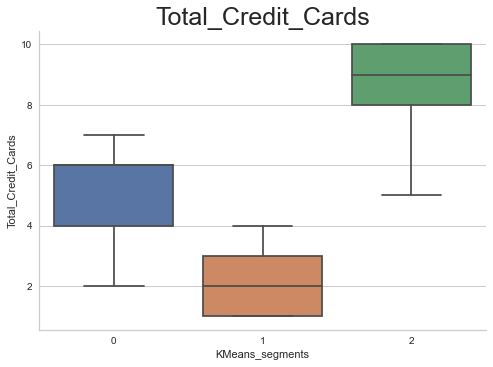

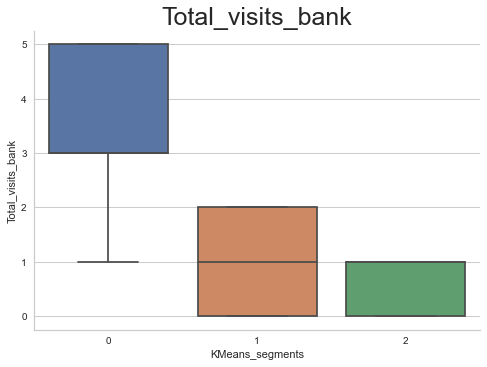

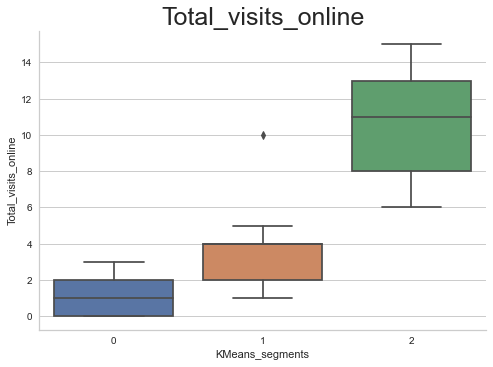

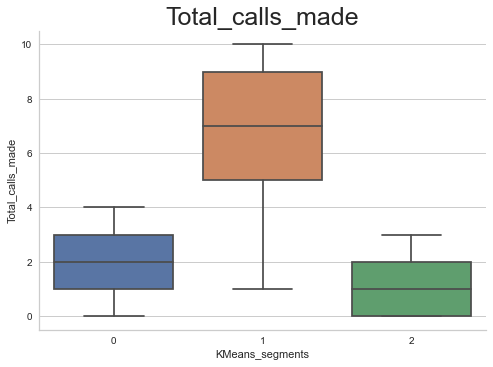

In [40]:
"""Generalized Boxplots to assess numerical features explcity to the target variable"""
features = pd.Series(cluster_df.drop(columns=["Monarch", "KMeans_segments"]).columns)
# plt.figure(figsize=(17, 75))
for i in range(len(features)):
#     plt.subplot(18, 3, i + 1)
    sns.boxplot(data=cluster_df, x='KMeans_segments', y=features[i], palette='deep')
    
#     plt.tight_layout()
    plt.title(features[i], fontsize=25)
    sns.despine()
    name = features[i] + "BoxPlot"
    plt.savefig(name, bbox_inches='tight', dpi=300)
    plt.show()

## Conclusions
- There are 3 primary types of customers that AllLIfe Bank.
- The most distinct one. Typically has high average credit card limits (upwards of \\$100,000), 8 or more credit cards, and strongly prefers to interact with AllLife Bank through online media. 
- Another segment, is largely defined by their preference to visit the bank in person. Otherwise, they tend to have average credit card limits less than \\$50,000, and have between 4 to 6 credit cards.
- The last segment, prefer to contact the bank through the phone. However, they may be more distinctly idenfited by their low average credit card limits (typically less than \\$25,000) and low number of credit cards (most have 3 or fewer).

Based on their characteristics, I am going to name give these groups generalized names based on their preference in contact from the bank. This means we have:
 - Online Customers
 - Personal Touch Customers
 - Phone Call Customers 

## Recommendation
### Current Customers
- Use KMeans Cluster algorithm to categorize your customers into groups based on preference: Online, Personal Touch, or Phone Call.
- Use that information to guide how you interact with those customers.
- In addition, use it to help target your marketing. For instance, Online users tend to have high average credit card limits and lots of cards, therefore, they may be less likely to on a new card. However, they may be more likely to take a loan.

### New Customers
If you can obtain data on potential customers credit card behavior I would use that information (Average Credit Card Limit and Total Credit Cards) to guide how best to advertise to a new customer. If they have higher numbers of cards and limits, online advertising and email may be the best route to contact them. If they have low numbers of cards and limits, mail and in particular signage or involvement of local branches in local community events to advertise are likely to be a better way to advertise to those individuals.